Andrew Dodd
, 2/21/18
# Machine Learning Project Notebook
## Table of Contents
### 1. Imports
### 2. Cleaning
### 3. Exploration/Unsupervised Learning
### 4. Modeling

## 1. Imports

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor 
from bayes_opt import BayesianOptimization


import matplotlib
import matplotlib.pyplot as plt

# import xgboost as xgb
%matplotlib inline

from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')

In [2]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline

house_train = pd.read_csv('./data/train.csv')
house_test = pd.read_csv('./data/test.csv')

house_train.rename(index=str, columns={"BedroomAbvGr":"Bedroom", "KitchenAbvGr":"Kitchen"},
                   inplace = True)
house_test.rename(index=str, columns={"BedroomAbvGr":"Bedroom", "KitchenAbvGr":"Kitchen"},
                    inplace = True)

names = list(house_test.columns.values)

FileNotFoundError: File b'./data/train.csv' does not exist

## 2. Cleaning
Here we do the cleaning for the data. This will include examining the dataset, value imputation, visualization, filling or removing NAs, etc.

### 2.1 Converting column types to numeric
Now that we have our dataset imported, we need to convert the numeric parts into numeric.

In [ ]:
with open("./data/data_description.txt") as f:
    content = f.readlines()
    
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content] 


prev_column = '' # Most recent column name
num_lines = 0 # number of lines since column name
i = 0
for line in content:
    if (re.search('^(.{1,20}):.*', line) != None) and (num_lines == 1):
        house_train[prev_column] = pd.to_numeric(house_train[prev_column],errors = 'coerce')
        house_test[prev_column] = pd.to_numeric(house_test[prev_column],errors = 'coerce')
    if line.strip() == '':
        num_lines += 1
        next
    if (re.search('^(.{1,20}):.*', line) != None):
        prev_column = (re.search('^(.{1,20}):.*', line)).group(1)
        num_lines = 0
    i += 1

# Showing some interesting values...
house_train.describe()

In [ ]:
# house_train.columns.to_series().groupby(house_train.dtypes).groups

### 2.2 Converting strings to factors and fixing values

Here we will figure out which train and test columns have values that are not a subset of the text file. In some cases, I will adjust these values.

In [ ]:
prev_column = '' # Most recent column name
i = 0      # Number of loop iterations
flag = 0   # This is an indicator of whether we want to be parsing column categories
           # 0 corresponds to no, 1 corresponds to yes
           # It is set to 1 once we pass a blank row.
start = 0  # This is the number of column categories we have iterated through so far

# MAKE A DICTIONARY HERE
all_col_categ = {}
one_category_list = []
category_counter = 0
columnName = ''

# Iterating through entire list of column names and their categories.
for line in content:
    # print("-"*60)
    # print("line number:  %d" %i)
    
    # Check if it's not a new column name, flag is 1, and line is not blank
    # Let's get a list of the data
    if (re.search('^(.{1,20}):.*', line) == None) and (flag == 1) and line.strip() != '':
        # Using regex, second match is what we want:
        category = re.search('^[ |\t]*?([A-Za-z0-9_-]*)[ |\t]*(.{1,50})?',line).group(1)
        one_category_list.append(category)
        category_counter += 1
        
    # Here we check if this is the blank line after all the category names of a column.
    # It checks that our flag is 1 and that we have a blank line.
    if (flag == 1) and line.strip() == '':
        all_col_categ[columnName]=one_category_list
        #all_col_categ.append(one_category_list)
        
    # Adding to the flag
    if line.strip() == '':
        flag += 1
        
    # Reset our flag to zero when we get to a new name
    if (re.search('^(.{1,20}):.*', line) != None):
        prev_column = (re.search('^(.{1,20}):.*', line)).group(1)
        one_category_list = []   # reset our category list to null
        columnName = re.search('^(.{1,20}):.*', line).group(1)
        flag = 0             # reset our flag to 0
        category_counter = 0 # reset our category counter
        
    i += 1
#Missed last category set:
last_categories = ['Normal','Abnormal','AdjLand','Alloca','Family','Partial']
all_col_categ['SaleCondition'] = last_categories

#print(all_col_categ)

Here we will go through all of the columns. In each column, we check if it is numeric. If it is not, we will compare the category options in the text file to the categories in the dataset. If they do not match, we print the column name.

In [ ]:
# Our two lists of column names are not in order together

j = 0
for i in range(len(names)):
    name = names[i]
    
    # If the column is not numeric, we will check the categories
    if isinstance(house_train[name][0], numbers.Number) == 0:  
#         print(i)
#         print('-'*100)
#         print(name)
        all_col_set = set(all_col_categ[name])   # set of all ~42 categories from columns.txt

        # Check if sets are equal for train and test set. If they are not, print them.
        
        train_col = house_train.iloc[:, [i]]
        set_unique_train = set(pd.unique(train_col.values.ravel()))
        test_col = house_test.iloc[:, [i]]
        set_unique_test = set(pd.unique(test_col.values.ravel()))
        
#         if set_unique_train.issubset(all_col_set)==0 or set_unique_test.issubset(all_col_set)==0:
#             print(all_col_set)
#             print('.'*50)
        
#         if set_unique_train.issubset(all_col_set)==0:
#             print("The train unique values are not contained in the set from columns.txt")
#             print(set_unique_train)
#             print('.'*50)
        
#         if set_unique_test.issubset(all_col_set)==0:
#             print("The test unique values are not contained in the set from columns.txt")
#             print(set_unique_test)
            
        #CHECK TEST TOO
        
        j += 1


Fixing misnamed values

In [ ]:
# MSZoning
mask = house_train.MSZoning == 'C (all)'
house_train.loc[mask, 'MSZoning'] = 'C'

# Utilities
# Interesting that the Utilities training set are all included, but test only has AllPub and nan...

# Neighborhood
mask = house_train.Neighborhood == 'NAmes'
house_train.loc[mask, 'Neighborhood'] = 'Names'
mask = house_test.Neighborhood == 'NAmes'
house_test.loc[mask, 'Neighborhood'] = 'Names'

# Building type: ignoring because the train and test match.

# House style - looks fine.
# Interestingly, 2.5 Fin is in only the training set, does not appear in test set.

# RoofMat1
# Train haas 4 more categories than test. Train has ClyTile, Metal, Membran, and Roll, which test does not have.

# Exterior1st
# Train has stone and ImStucc (test does not have these.)
# Test does not have ImStucc at all. Also has nan.
# Maybe we want to change ImStucc in to Stucc in train set?

# Exterior2nd
# nan is included in test, but not in train

# MasVnrType
# No Cblock, but we do have nans

# I did not write all the mismatched columns. The above is about half of them.
# I don't think we need to change any of the values to something else at this moment. 
# Next we'll look at nans.

### 2.3  Fixing all the NaNs

In [ ]:
########################################## TRAIN #######################################
mask = house_train.Alley.isnull()
house_train.loc[mask, 'Alley'] = 'No'

mask = house_train.PoolQC.isnull()
house_train.loc[mask, 'PoolQC'] = 'No'

mask = house_train.FireplaceQu.isnull()
house_train.loc[mask, 'FireplaceQu'] = 'No'

mask = house_train.Fence.isnull()
house_train.loc[mask, 'Fence'] = 'No'

mask = house_train.MiscFeature.isnull()
house_train.loc[mask, 'MiscFeature'] = 'No'

# Garage
mask = house_train.GarageType.isnull()
house_train.loc[mask, 'GarageType'] = 'No'

mask = house_train.GarageFinish.isnull()
house_train.loc[mask, 'GarageFinish'] = 'No'

mask = house_train.GarageCond.isnull()
house_train.loc[mask, 'GarageCond'] = 'No'

mask = house_train.GarageQual.isnull()
house_train.loc[mask, 'GarageQual'] = 'No'

# Basement
mask = house_train.BsmtQual.isnull()
house_train.loc[mask, 'BsmtQual'] = 'No'

mask = house_train.BsmtCond.isnull()
house_train.loc[mask, 'BsmtCond'] = 'No'

#mask = house_train.BsmtExposure.isnull()
#house_train.loc[mask, 'BsmtExposure'] = 'No'

mask = house_train.BsmtFinType1.isnull()
house_train.loc[mask, 'BsmtFinType1'] = 'No'

mask = house_train.BsmtFinType2.isnull()
house_train.loc[mask, 'BsmtFinType2'] = 'No'

# Other
mask = house_train.MasVnrType.isnull()
house_train.loc[mask, 'MasVnrType'] = 'No'

mask = house_train.MasVnrArea.isnull()
house_train.loc[mask, 'MasVnrArea'] = 0



########################################## TEST #######################################
mask = house_test.Alley.isnull()
house_test.loc[mask, 'Alley'] = 'No'

mask = house_test.PoolQC.isnull()
house_test.loc[mask, 'PoolQC'] = 'No'

mask = house_test.FireplaceQu.isnull()
house_test.loc[mask, 'FireplaceQu'] = 'No'

mask = house_test.Fence.isnull()
house_test.loc[mask, 'Fence'] = 'No'

mask = house_test.MiscFeature.isnull()
house_test.loc[mask, 'MiscFeature'] = 'No'

# Garage
mask = house_test.GarageType.isnull()
house_test.loc[mask, 'GarageType'] = 'No'

mask = house_test.GarageFinish.isnull()
house_test.loc[mask, 'GarageFinish'] = 'No'

mask = house_test.GarageCond.isnull()
house_test.loc[mask, 'GarageCond'] = 'No'

mask = house_test.GarageQual.isnull()
house_test.loc[mask, 'GarageQual'] = 'No'

# Basement
mask = house_test.BsmtQual.isnull()
house_test.loc[mask, 'BsmtQual'] = 'No'

mask = house_test.BsmtCond.isnull()
house_test.loc[mask, 'BsmtCond'] = 'No'

#mask = house_test.BsmtExposure.isnull()
#house_test.loc[mask, 'BsmtExposure'] = 'No'

mask = house_test.BsmtFinType1.isnull()
house_test.loc[mask, 'BsmtFinType1'] = 'No'

mask = house_test.BsmtFinType2.isnull()
house_test.loc[mask, 'BsmtFinType2'] = 'No'

# Other
mask = house_test.MasVnrType.isnull()
house_test.loc[mask, 'MasVnrType'] = 'No'

mask = house_test.MasVnrArea.isnull()
house_test.loc[mask, 'MasVnrArea'] = 0

In [ ]:
# Examining year built and garage, maybe we should have our GarageYrBlt nans be YearBuilt? 
# Perhaps this is not true though...
sns.lmplot('GarageYrBlt', # Horizontal axis
           'YearBuilt', # Vertical axis
           data=house_train, # Data source
           fit_reg=False, # Don't fix a regression line
           #hue="z", # Set color
           scatter_kws={"marker": "D", # Set marker style
                        "s": 100}) # S marker size

# I think it is fair to say this...it probably just means that there is no garage...
mask = house_test.GarageYrBlt.isnull()
house_test.loc[mask, 'GarageYrBlt'] = house_test.YearBuilt

mask = house_train.GarageYrBlt.isnull()
house_train.loc[mask, 'GarageYrBlt'] = house_train.YearBuilt


Filling in the last remaining NaNs with KNN:
 * Lot Frontage (~300)
 * Electrical (1)
 * 

In [ ]:
# from fancyimpute import KNN 

# house_train = KNN(k=20).complete(house_train)
# house_test = KNN(k=20).complete(house_test)

# Filling in the numeric with the median value.
# here we impute the median of a bunch of 1 nans (number of basement bathrooms)
# The larger imputation here for error causing is lot frontage, with around ~300 imputations.
house_train.fillna(house_train.median(),inplace = True)
house_test.fillna(house_test.median(),inplace = True)

# Filling in the categoricals with the median value.
house_train = house_train.apply(lambda x:x.fillna(x.value_counts().index[0]))
house_test = house_test.apply(lambda x:x.fillna(x.value_counts().index[0]))

# Test
for i in range(len(names)):
    s = house_test.iloc[:,i]
    sum1 = s.isnull().sum()
    if sum1 != 0:
        print(names[i])
        print(sum1)

# Train
for i in range(len(names)):
    s = house_train.iloc[:,i]
    sum1 = s.isnull().sum()
    if sum1 != 0:
        print(names[i])
        print(sum1)
        
# Nothing printed means no more NAs! Now we can do other stuff!

### 2.3 Converting ordinal categories into numeric.

Here we will convert the following columns from categorical to numeric:
* GarageQual
* GarageCond
* FireplaceQu
* KitchenQual
* HeatingQC
* BsmtCond
* BsmtQual
* ExterCond
* ExterQual

In [2]:
train_col = house_train.iloc[:, [28]]
set_unique_train = set(pd.unique(train_col.values.ravel()))
print(set_unique_train)
print(names[28])

NameError: name 'house_train' is not defined

In [3]:
#########################################
# TRAIN
#########################################

qual_dict = {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5,
            0:0, 1:1, 2:2, 3:3, 4:4, 5:5}
house_train["ExterQual"] = house_train["ExterQual"].map(qual_dict).astype(int)
house_train["ExterCond"] = house_train["ExterCond"].map(qual_dict).astype(int)
house_train["BsmtQual"] = house_train["BsmtQual"].map(qual_dict).astype(int)
house_train["BsmtCond"] = house_train["BsmtCond"].map(qual_dict).astype(int)
house_train["HeatingQC"] = house_train["HeatingQC"].map(qual_dict).astype(int)
house_train["KitchenQual"] = house_train["KitchenQual"].map(qual_dict).astype(int)
house_train["FireplaceQu"] = house_train["FireplaceQu"].map(qual_dict).astype(int)
house_train["GarageQual"] = house_train["GarageQual"].map(qual_dict).astype(int)
house_train["GarageCond"] = house_train["GarageCond"].map(qual_dict).astype(int)

#########################################
# TEST
#########################################

qual_dict = {"No": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5,
            0:0, 1:1, 2:2, 3:3, 4:4, 5:5}
house_test["ExterQual"] = house_test["ExterQual"].map(qual_dict).astype(int)
house_test["ExterCond"] = house_test["ExterCond"].map(qual_dict).astype(int)
house_test["BsmtQual"] = house_test["BsmtQual"].map(qual_dict).astype(int)
house_test["BsmtCond"] = house_test["BsmtCond"].map(qual_dict).astype(int)
house_test["HeatingQC"] = house_test["HeatingQC"].map(qual_dict).astype(int)
house_test["KitchenQual"] = house_test["KitchenQual"].map(qual_dict).astype(int)
house_test["FireplaceQu"] = house_test["FireplaceQu"].map(qual_dict).astype(int)
house_test["GarageQual"] = house_test["GarageQual"].map(qual_dict).astype(int)
house_test["GarageCond"] = house_test["GarageCond"].map(qual_dict).astype(int)

NameError: name 'house_train' is not defined

In [ ]:
#########################################
# TRAIN
#########################################

house_train["BsmtExposure"] = house_train["BsmtExposure"].map({None: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4,
                                                              0:0, 1:1, 2:2, 3:3, 4:4}).astype(int)

bsmt_fin_dict = {"No": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6,
                0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6}
house_train["BsmtFinType1"] = house_train["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
house_train["BsmtFinType2"] = house_train["BsmtFinType2"].map(bsmt_fin_dict).astype(int)

house_train["Functional"] = house_train["Functional"].map(
        {"No": 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
         "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8, 
          0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8}).astype(int)

house_train["GarageFinish"] = house_train["GarageFinish"].map(
        {"No": 0, "Unf": 1, "RFn": 2, "Fin": 3, 0:0, 1:1, 2:2, 3:3}).astype(int)

house_train["Fence"] = house_train["Fence"].map(
        {"No": 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4,
         0:0, 1:1, 2:2, 3:3, 4:4}).astype(int)

house_train["CentralAir"] = house_train["CentralAir"].map(
        {"N": 0, "Y": 1,
         0:0, 1:1}).astype(int)

#########################################
# TEST
#########################################

house_test["BsmtExposure"] = house_test["BsmtExposure"].map({None: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4,
                                                              0:0, 1:1, 2:2, 3:3, 4:4}).astype(int)

bsmt_fin_dict = {"No": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6,
                0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6}
house_test["BsmtFinType1"] = house_test["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
house_test["BsmtFinType2"] = house_test["BsmtFinType2"].map(bsmt_fin_dict).astype(int)

house_test["Functional"] = house_test["Functional"].map(
        {"No": 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
         "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8, 
          0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8}).astype(int)

house_test["GarageFinish"] = house_test["GarageFinish"].map(
        {"No": 0, "Unf": 1, "RFn": 2, "Fin": 3, 0:0, 1:1, 2:2, 3:3}).astype(int)

house_test["Fence"] = house_test["Fence"].map(
        {"No": 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4,
         0:0, 1:1, 2:2, 3:3, 4:4}).astype(int)

house_test["CentralAir"] = house_test["CentralAir"].map(
        {"N": 0, "Y": 1,
         0:0, 1:1}).astype(int)

In [ ]:
x = house_train.columns.to_series().groupby(house_train.dtypes).groups
# print(x)

In [ ]:
#MJG
house_train_orig = house_train
house_test_orig = house_test

### 2.4 Non-ordinal Categorical Variables and Feature Engineering

In [ ]:
#########################################
# TRAIN
#########################################

# IR2 and IR3 don't appear that often, so just make a distinction
# between regular and irregular.
house_train["IsRegularLotShape"] = (house_train["LotShape"] == "Reg") * 1

# Most properties are level; bin the other possibilities together
# as "not level".
house_train["IsLandLevel"] = (house_train["LandContour"] == "Lvl") * 1

# Most land slopes are gentle; treat the others as "not gentle".
house_train["IsLandSlopeGentle"] = (house_train["LandSlope"] == "Gtl") * 1

# Most properties use standard circuit breakers.
house_train["IsElectricalSBrkr"] = (house_train["Electrical"] == "SBrkr") * 1

# About 2/3rd have an attached garage.
house_train["IsGarageDetached"] = (house_train["GarageType"] == "Detchd") * 1

# Most have a paved drive. Treat dirt/gravel and partial pavement
# as "not paved".
house_train["IsPavedDrive"] = (house_train["PavedDrive"] == "Y") * 1

# The only interesting "misc. feature" is the presence of a shed.
house_train["HasShed"] = (house_train["MiscFeature"] == "Shed") * 1.  

# If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
house_train["Remodeled"] = (house_train["YearRemodAdd"] != house_train["YearBuilt"]) * 1
    
# Did a remodeling happen in the year the house was sold?
house_train["RecentRemodel"] = (house_train["YearRemodAdd"] == house_train["YrSold"]) * 1
    
# Was this house sold in the year it was built?
house_train["VeryNewHouse"] = (house_train["YearBuilt"] == house_train["YrSold"]) * 1

#########################################
# TEST
#########################################

# IR2 and IR3 don't appear that often, so just make a distinction
# between regular and irregular.
house_test["IsRegularLotShape"] = (house_test["LotShape"] == "Reg") * 1

# Most properties are level; bin the other possibilities together
# as "not level".
house_test["IsLandLevel"] = (house_test["LandContour"] == "Lvl") * 1

# Most land slopes are gentle; treat the others as "not gentle".
house_test["IsLandSlopeGentle"] = (house_test["LandSlope"] == "Gtl") * 1

# Most properties use standard circuit breakers.
house_test["IsElectricalSBrkr"] = (house_test["Electrical"] == "SBrkr") * 1

# About 2/3rd have an attached garage.
house_test["IsGarageDetached"] = (house_test["GarageType"] == "Detchd") * 1

# Most have a paved drive. Treat dirt/gravel and partial pavement
# as "not paved".
house_test["IsPavedDrive"] = (house_test["PavedDrive"] == "Y") * 1

# The only interesting "misc. feature" is the presence of a shed.
house_test["HasShed"] = (house_test["MiscFeature"] == "Shed") * 1.  

# If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
house_test["Remodeled"] = (house_test["YearRemodAdd"] != house_test["YearBuilt"]) * 1
    
# Did a remodeling happen in the year the house was sold?
house_test["RecentRemodel"] = (house_test["YearRemodAdd"] == house_test["YrSold"]) * 1
    
# Was this house sold in the year it was built?
house_test["VeryNewHouse"] = (house_test["YearBuilt"] == house_test["YrSold"]) * 1

More feature engineering, a lot of it coming from:
https://www.kaggle.com/humananalog/xgboost-lasso/code

In [ ]:
# More feature engineering...

#########################################
# TRAIN
#########################################

house_train["Has2ndFloor"] = (house_train["2ndFlrSF"] == 0) * 1
house_train["HasMasVnr"] = (house_train["MasVnrArea"] == 0) * 1
house_train["HasWoodDeck"] = (house_train["WoodDeckSF"] == 0) * 1
house_train["HasOpenPorch"] = (house_train["OpenPorchSF"] == 0) * 1
house_train["HasEnclosedPorch"] = (house_train["EnclosedPorch"] == 0) * 1
house_train["Has3SsnPorch"] = (house_train["3SsnPorch"] == 0) * 1
house_train["HasScreenPorch"] = (house_train["ScreenPorch"] == 0) * 1

# Months with the largest number of deals may be significant.
house_train["HighSeason"] = house_train["MoSold"].replace( 
        {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})

house_train["NewerDwelling"] = house_train["MSSubClass"].replace(
        {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
         90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})   
    
house_train.loc[house_train.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
house_train.loc[house_train.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
house_train.loc[house_train.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
house_train.loc[house_train.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
house_train.loc[house_train.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
house_train["Neighborhood_Good"].fillna(0, inplace=True)

house_train["SaleCondition_PriceDown"] = house_train.SaleCondition.replace(
        {'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

# House completed before sale or not
house_train["BoughtOffPlan"] = house_train.SaleCondition.replace(
        {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
    
house_train["BadHeating"] = house_train.HeatingQC.replace(
        {5: 0, 4: 0, 3: 0, 2: 1, 1: 1, 0:0})

area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
house_train["TotalArea"] = house_train[area_cols].sum(axis=1)

house_train["TotalArea1st2nd"] = house_train["1stFlrSF"] + house_train["2ndFlrSF"]

house_train["Age"] = 2010 - house_train["YearBuilt"]
house_train["TimeSinceSold"] = 2010 - house_train["YrSold"]

house_train["SeasonSold"] = house_train["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 
                                                  6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
    
house_train["YearsSinceRemodel"] = house_train["YrSold"] - house_train["YearRemodAdd"]

#########################################
# TEST
#########################################

house_test["Has2ndFloor"] = (house_test["2ndFlrSF"] == 0) * 1
house_test["HasMasVnr"] = (house_test["MasVnrArea"] == 0) * 1
house_test["HasWoodDeck"] = (house_test["WoodDeckSF"] == 0) * 1
house_test["HasOpenPorch"] = (house_test["OpenPorchSF"] == 0) * 1
house_test["HasEnclosedPorch"] = (house_test["EnclosedPorch"] == 0) * 1
house_test["Has3SsnPorch"] = (house_test["3SsnPorch"] == 0) * 1
house_test["HasScreenPorch"] = (house_test["ScreenPorch"] == 0) * 1

# Months with the largest number of deals may be significant.
house_test["HighSeason"] = house_test["MoSold"].replace( 
        {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})

house_test["NewerDwelling"] = house_test["MSSubClass"].replace(
        {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
         90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})   
    
house_test.loc[house_test.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
house_test.loc[house_test.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
house_test.loc[house_test.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
house_test.loc[house_test.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
house_test.loc[house_test.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
house_test["Neighborhood_Good"].fillna(0, inplace=True)

house_test["SaleCondition_PriceDown"] = house_test.SaleCondition.replace(
        {'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

# House completed before sale or not
house_test["BoughtOffPlan"] = house_test.SaleCondition.replace(
        {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
    
house_test["BadHeating"] = house_test.HeatingQC.replace(
        {5: 0, 4: 0, 3: 0, 2: 1, 1: 1, 0:0})

area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
house_test["TotalArea"] = house_test[area_cols].sum(axis=1)

house_test["TotalArea1st2nd"] = house_test["1stFlrSF"] + house_test["2ndFlrSF"]

house_test["Age"] = 2010 - house_test["YearBuilt"]
house_test["TimeSinceSold"] = 2010 - house_test["YrSold"]

house_test["SeasonSold"] = house_test["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 
                                                  6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
    
house_test["YearsSinceRemodel"] = house_test["YrSold"] - house_test["YearRemodAdd"]

Now we add in some neighborhood information:

In [ ]:

    
# Bin by neighborhood (a little arbitrarily). Values were computed by: 
# train_df["SalePrice"].groupby(train_df["Neighborhood"]).median().sort_values()
neighborhood_map = {
        "MeadowV" : 0,  #  88000
        "IDOTRR" : 1,   # 103000
        "BrDale" : 1,   # 106000
        "OldTown" : 1,  # 119000
        "Edwards" : 1,  # 119500
        "BrkSide" : 1,  # 124300
        "Sawyer" : 1,   # 135000
        "Blueste" : 1,  # 137500
        "SWISU" : 2,    # 139500
        "Names" : 2,    # 140000
        "NPkVill" : 2,  # 146000
        "Mitchel" : 2,  # 153500
        "SawyerW" : 2,  # 179900
        "Gilbert" : 2,  # 181000
        "NWAmes" : 2,   # 182900
        "Blmngtn" : 2,  # 191000
        "CollgCr" : 2,  # 197200
        "ClearCr" : 3,  # 200250
        "Crawfor" : 3,  # 200624
        "Veenker" : 3,  # 218000
        "Somerst" : 3,  # 225500
        "Timber" : 3,   # 228475
        "StoneBr" : 4,  # 278000
        "NoRidge" : 4,  # 290000
        "NridgHt" : 4,  # 315000
}

house_train["NeighborhoodBin"] = house_train["Neighborhood"].map(neighborhood_map)
house_test["NeighborhoodBin"] = house_test["Neighborhood"].map(neighborhood_map)

Let's see if the USA market housing fluxuations affected this small town. We can put all the points on a plot...

In [ ]:
sns.lmplot('YearBuilt', # Horizontal axis
           'SalePrice', # Vertical axis
           data=house_train, # Data source
           fit_reg=False, # Don't fix a regression line
           scatter_kws={"marker": "D", # Set marker style
                        "alpha": .2,
                        "s": 1}) # S marker size

# There is a definite trend here in price, but this might be learned from the year columns...

In [ ]:
# house_train.columns.to_series().groupby(house_train.dtypes).groups

Now we have done some good feature engineering. For the rest of the categorical features that are left, we can either omit them or use them as one hot features (get_dummies). We'll see what's best in the future.

### 2.5 Removing Outliers

In order to refine our algorithm we are going to want to remove outliers, points that are too far beyond the realm of likelihood...

In [ ]:
sns.lmplot('GrLivArea', # Horizontal axis
           'SalePrice', # Vertical axis
           data=house_train, # Data source
           fit_reg=False, # Don't fix a regression line
           scatter_kws={"marker": "D", # Set marker style
                        "alpha": .2,
                        "s": 1}) # S marker size

In [ ]:
# Based on the author's paper, we will remove some of the outliers:
house_train = house_train.drop(house_train[(house_train.GrLivArea > 4000) & (house_train['SalePrice']<300000)].index)

### 2.6 MJG - Removing Unncessary Columns

Now that we got a bunch of dummy columns, we got to do some cleaning and dropping things that have zero variance or near zero variance within itself or with SalePrice. After we will do some cleaning on what columns we should drop since they have been one-hot encoded

In [ ]:
##MJG
#looking at Shu's class code to see what should be dropped for zero variance or near zero variance
full_df = pd.concat(( house_train, house_test ))
# full_df =full_df.drop(['Street', 'Utilities', "Condition2", "RoofMatl", "PoolQC", 
#              "MiscVal", "LandSlope", "LowQualFinSF", "PoolArea", "3SsnPorch", "Has3SsnPorch"],axis=1)
# full_df

In [ ]:
##MJG
full_df_dummies  = pd.get_dummies(full_df)

temp = full_df_dummies["SalePrice"]
del full_df_dummies["SalePrice"]
full_df_dummies["SalePrice"] = temp
full_df_dummies

In [ ]:
full_df_dummies["SalePrice"].isnull()

## 3.0 Exploration, Unsupervised Learning

Now we want to look for some more structure in the data. Are there discernible groups? What features are the primary drivers of SalePrice?

First we will make some dummies for the categorical features so we can do PCA. 

In [ ]:
house_train_d = full_df_dummies[0:1456]
house_test_d = full_df_dummies[1456:2915]

house_test_d.drop(['SalePrice'], axis=1, inplace = True)

# Putting SalePrice last, check that the columns are in same order...
names = list(house_train_d.columns.values)
cols = house_train_d.columns.tolist()
cols = cols[0:70] + cols[71:269] + [cols[70]]
house_train_d = house_train_d[cols] 

# Sanity Check
print(house_train.shape)
print(house_test.shape)
print(house_train_d.shape)
print(house_test_d.shape)

In [ ]:
pca = PCA(n_components=5)
pca.fit(house_train_d)
pca.components_ 

In [ ]:
X = house_train_d.ix[:,1:267].values
y = house_train_d.ix[:,267].values

X_std = StandardScaler().fit_transform(X)

In [ ]:
#MJG
X = house_train_orig

In [ ]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# print('Eigenvectors \n%s' %eig_vecs)
# print('\nEigenvalues \n%s' %eig_vals)

# for ev in eig_vecs:
#     np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
# print('Everything ok!')




tot = sum(eig_vals.real)
var_exp = [(i / tot)*100 for i in sorted(eig_vals.real, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

trace1 = Bar(
        x=['PC %s' %i for i in range(1,268)],
        y=var_exp,
        showlegend=False)

trace2 = Scatter(
        x=['PC %s' %i for i in range(1,268)], 
        y=cum_var_exp,
        name='cumulative explained variance')

data = Data([trace1, trace2])

layout=Layout(
        yaxis=YAxis(title='Explained variance in percent'),
        title='Explained variance by different principal components')

fig = Figure(data=data, layout=layout)

# We see from this plot that the we could possibly reduce our features if we had the inclination...
# I do not have the inclination at this time.
plot(fig)

## 4. Modeling and Prediction

Here we add some potential models...

Reference: 
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
https://www.kaggle.com/humananalog/xgboost-lasso/code

### 4.1 Model 1: Linear, Lasso

In [160]:

#########################################################################
##### NOTE THE LOG, This is because error is calculated using log #######
#########################################################################

train = house_train.ix[:,1:-1]
target = house_train.ix[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [162]:
# Lasso
regr = Lasso(alpha=.0005, max_iter=50000, tol = .0001)
regr.fit(train, target)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = regr.predict(X_test)

ValueError: shapes (292,82) and (81,) not aligned: 82 (dim 1) != 81 (dim 0)

In [157]:
def rmsle(y_true,y_pred):
   assert len(y_true) == len(y_pred)
   return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

log_error = rmsle(y_test, y_pred)
print(log_error)

NameError: name 'y_pred' is not defined

In [86]:
def rmse(y_true,y_pred):
   assert len(y_true) == len(y_pred)
   return np.square((y_pred + 1) - (y_true + 1)).mean() ** 0.5

In [ ]:
# Creating a scatter plot of the above results:
ax = sns.regplot(x=y_pred, y=y_test,
                 scatter_kws={"marker": "D", # Set marker style
                        "alpha": .5,
                        "s": 3})
# Perfect world is a straight line.
# Not too bad. Definitely room for improvement!

### 4.1.O - MJG Optimizing Elastic Net

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [164]:
[i for i in sorted(y_train)]

['SalePrice']

In [165]:
#MJG
def predict_ElasticNetCV(X_train, y_train):
    '''
    Function: Finding the optimal parameters for ElasticNet
    '''
    ELNCV_model = ElasticNetCV(l1_ratio=np.arange(0.01,1,.1), #the Alpha in the alphalasso+1-alpharidge
                 eps=0.001, 
                 alphas=np.arange(100,1000, 50), #Actual regularization term
                 normalize=False, 
                 max_iter=10000, #can potentially change, max iterations and tolerance can change
                 cv=3,  #can play with this from 3-10
                 n_jobs=-1, 
                 random_state=None)
    ELNCV_model.fit(X_train, y_train)
    return ELNCV_model

In [166]:
m1 = predict_ElasticNetCV(X_train, y_train.values.ravel())
# model = forest.fit(train_fold, train_y.values.ravel())

In [167]:
predictions = m1.predict(X_test)
# print((predictions-y_test.values.ravel())/y_test.values.ravel())
mse = rmse(predictions, y_test.values.ravel())
mse

2.0449057800454082

In [147]:
param = {"l1_ratio":np.arange(0,1,.01), "alpha":np.arange(200,1000,25)}
EN_grid = GridSearchCV(ElasticNet(), 
             param, 
             scoring="neg_mean_squared_error", 
             fit_params=None,
             n_jobs=-1,
             iid=True,
             refit=True,
             return_train_score = True,
             cv=3)
EN_grid.fit(X_train,y_train)

C:\Users\mjgol\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'l1_ratio': array([ 0.  ,  0.01, ...,  0.98,  0.99]), 'alpha': array([200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500,
       525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825,
       850, 875, 900, 925, 950, 975])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [129]:

EN_grid.best_params_
# print(min(y_train))
# np.mean(((np.log(np.abs(EN_grid.predict(X_test))+1) - np.log(np.abs(y_test)))**2)**0.5)
# best_index_, best_score_ and best_parameters_
rmse(EN_grid.predict(X_test),y_test.values.ravel())

2.0426245472260587

In [ ]:
>>> from sklearn import svm, datasets
>>> from sklearn.model_selection import GridSearchCV
>>> iris = datasets.load_iris()
>>> parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
>>> svc = svm.SVC()
>>> clf = GridSearchCV(svc, parameters)
>>> clf.fit(iris.data, iris.target)
...                             
GridSearchCV(cv=None, error_score=...,
       estimator=SVC(C=1.0, cache_size=..., class_weight=..., coef0=...,
                     decision_function_shape='ovr', degree=..., gamma=...,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=...,
                     verbose=False),
       fit_params=None, iid=..., n_jobs=1,
       param_grid=..., pre_dispatch=..., refit=..., return_train_score=...,
       scoring=..., verbose=...)
>>> sorted(clf.cv_results_.keys())
...                             
['mean_fit_time', 'mean_score_time', 'mean_test_score',...
 'mean_train_score', 'param_C', 'param_kernel', 'params',...
 'rank_test_score', 'split0_test_score',...
 'split0_train_score', 'split1_test_score', 'split1_train_score',...
 'split2_test_score', 'split2_train_score',...
 'std_fit_time', 'std_score_time', 'std_test_score', 'std_train_score'...]

### 4.2 Model 2: Random Forest

In [43]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=40, max_depth=10, random_state=0)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

log_error = rmsle(y_test, y_pred)
print(log_error)

# Not the best score...

0.0110694084928


### 4.3 Model 3: Kernel Ridge

In [ ]:
from sklearn.ensemble import RandomForestRegressor

KRR = KernelRidge(alpha=1000000, kernel='polynomial', degree=2, coef0=2.5)
KRR.fit(X_train,y_train)

y_pred = KRR.predict(X_test)

log_error = rmsle(y_test, y_pred)
print(log_error)

# Alpha higher than this leads to worse score...

### 4.4 More Complex Sklearn Models (Work in progress)

In [70]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
# import xgboost as xgb
# import lightgbm as lgb

In [ ]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = np.sqrt(-cross_val_score(model, train, target, scoring="neg_mean_squared_error", cv=cv))
    return score

#Models:
# lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

# ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

# KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

# GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
#                                    max_depth=4, max_features='sqrt',
#                                    min_samples_leaf=15, min_samples_split=10, 
#                                    loss='huber', random_state =5)

# model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
#                               learning_rate=0.05, n_estimators=720,
#                               max_bin = 55, bagging_fraction = 0.8,
#                               bagging_freq = 5, feature_fraction = 0.2319,
#                               feature_fraction_seed=9, bagging_seed=9,
#                               min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

# score = rmsle_cv(lasso)
# print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

### 5. Write to CSV (results, data, etc)

In [ ]:
# Here we are writing our cleaned dataframe to a CSV...

In [82]:
house_train_d.to_csv("train_dummies.csv")
house_test_d.to_csv("test_dummies.csv")

NameError: name 'house_train_d' is not defined

# Running models

In [8]:
y_pred = lasso_fit.predict(X_test)
# log_error = rmsle(y_test, y_pred)
# print(log_error)

NameError: name 'lasso_fit' is not defined

In [67]:
def rmsle(y_true,y_pred):
   assert len(y_true) == len(y_pred)
   #return np.square(y_pred - y_true).mean() ** 0.5
   return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

# log_error = rmsle(y_test, y_pred)
# print(log_error)

In [10]:
def rmse(y_true,y_pred):
   assert len(y_true) == len(y_pred)
   return np.square(y_pred + 1 - y_true + 1).mean() ** 0.5

# log_error = rmse(y_test, y_pred)
# print(log_error)

# MAKING OF MODELS

### Peter's data

In [11]:
house_train = pd.read_csv('D:/NYC-Data-Science/Projects/HousingPricesML/Data/train_linear.csv')
# house_test = pd.read_csv('D:/NYC-Data-Science/Projects/HousingPricesML/test_linear.csv')
house_train = house_train.drop("Unnamed: 0", axis = 1)
# house_test = house_test.drop("Unnamed: 0", axis = 1)
# house_train

### Roger's data

In [3]:
house_train = pd.read_csv('D:/NYC-Data-Science/Projects/HousingPricesML/Data/train_120feats_Dense_OutlierFree_LogTransform.csv')
house_train = house_train.drop("Unnamed: 0", axis = 1)
house_train

,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,GrLivArea,Bedroom,Kitchen,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,BsmtBath,Bath,2Materials,MSZoning_RL,MSZoning_RM,Alley_No,LotShape_Reg,LotShape_IR1,LandContour_Lvl,LotConfig_Inside,LotConfig_Corner,LandSlope_Gtl,Condition1_Norm,BldgType_1Fam,HouseStyle_1Story,HouseStyle_2Story,RoofStyle_Gable,RoofStyle_Hip,Exterior1st_VinylSd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Wd Sdng,Exterior2nd_VinylSd,Exterior2nd_MetalSd,Exterior2nd_HdBoard,MasVnrType_None,MasVnrType_BrkFace,Foundation_PConc,Foundation_CBlock,BsmtExposure_No,BsmtExposure_Av,Heating_GasA,Electrical_SBrkr,GarageType_Attchd,GarageType_Detchd,PavedDrive_Y,MiscFeature_No,SaleType_WD,SaleCondition_Normal,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_150,SalePrice
0,3,4.189655,9.042040,2,1,2,1,1,197200.0,3,2,4,7,5,2003,2003,2,3,2,2,5.283204,4,3,3,4,3,1,6,6.561031,1,0.000000,5.017280,6.753438,3,5,1,3,6.751101,7.444833,3,0.693147,4,8,8,0,0,2,2003.0,2,548,3,3,3,0.000000,4.127134,0.000000,0.000000,0.000000,0,2,2,2008,2,1,1.0,2.5,0,1,0,1,1,0,1,1,0,1,1,1,0,1,1,0,1,0,0,0,1,0,0,0,1,1,0,1,0,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,12.247699
1,3,4.394449,9.169623,2,1,2,1,1,206000.0,2,2,3,6,8,1976,1976,2,4,2,1,0.000000,3,3,1,4,3,3,5,6.886532,1,0.000000,5.652489,7.141245,3,5,1,3,0.000000,7.141245,3,0.693147,3,6,8,1,3,2,1976.0,2,460,3,3,3,5.700444,0.000000,0.000000,0.000000,0.000000,0,2,5,2007,2,1,0.5,2.0,0,1,0,1,1,0,1,0,0,1,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,1,1,0,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,12.109016
2,3,4.234107,9.328212,2,2,2,1,1,197200.0,3,2,4,7,5,2001,2002,2,3,2,2,5.093750,4,3,3,4,3,2,6,6.188264,1,0.000000,6.075346,6.825460,3,5,1,3,6.765039,7.488294,3,0.693147,4,6,8,1,3,2,2001.0,2,608,3,3,3,0.000000,3.761200,0.000000,0.000000,0.000000,0,2,9,2008,2,1,1.0,2.5,0,1,0,1,0,1,1,1,0,1,1,1,0,1,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,12.317171
3,3,4.110874,9.164401,2,2,2,1,1,200624.0,3,2,4,7,5,1915,1970,2,4,2,1,0.000000,3,3,1,3,4,1,5,5.379897,1,0.000000,6.293419,6.629363,3,4,1,3,6.629363,7.448916,3,0.693147,4,7,8,1,4,1,1998.0,1,642,3,3,3,0.000000,3.583519,5.609472,0.000000,0.000000,0,2,2,2006,2,1,1.0,1.0,1,1,0,1,0,1,1,0,1,1,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,11.849405
4,3,4.442651,9.565284,2,2,2,1,1,301500.0,3,2,4,8,5,2000,2000,2,3,2,2,5.860786,4,3,3,4,3,2,6,6.486161,1,0.000000,6.196444,7.044033,3,5,1,3,6.960348,7.695758,4,0.693147,4,9,8,1,3,2,2000.0,2,836,3,3,3,5.262690,4.442651,0.000000,0.000000,0.000000,0,2,12,2008,2,1,1.0,2.5,0,1,0,1,0,1,1,0,0,1,1,1,0,1,1,0,1,0,0,0,1,0,0,0,1,1,0,0,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,12.429220
5,3,4.454347,9.555064,2,2,2,1,1,154750.0,3,2,2,5,5,1993,1995,2,3,2,1,0.000000,3,3,2,4,3,1,6,6.597146,1,0.000000,4.174387,6.680855,3,5,1,3,6.340359,7.217443,1,0.693147,3,5,8,0,0,2,1993.0,1,480,3,3,3,3.713572,3.433987,0.000000,5.771441,0.000000,3,2,10,2009,2,1,1.0,1.5,0,1,0,1,0,1,1,1,0,1,1,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,11.870607
6,3,4.330733,9.218804,2,1,2,1,1,225500.0,3,2,3,8,5,2004,2005,2,3,2,3,5.231109,4,3,3,5,3,2,6,7.222566,1,0.000000,5.762051,7.430707,3,5,1,3,0.000000,7.435438,3,0.693147,4,7

In [4]:
X = house_train.loc[:, house_train.columns != 'SalePrice']
y = house_train.loc[:, house_train.columns == "SalePrice"]

In [5]:
def rmse_cv(model):
    rmse = np.sqrt( -cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [8]:
house_train = house_train.fillna(house_train.median())
# house_train


# LASSO

In [9]:
X = house_train.loc[:, house_train.columns != 'SalePrice']
y = house_train.SalePrice

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [12]:
model_Lasso = Lasso()

In [13]:
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

# LASSO ATTEMPT 2

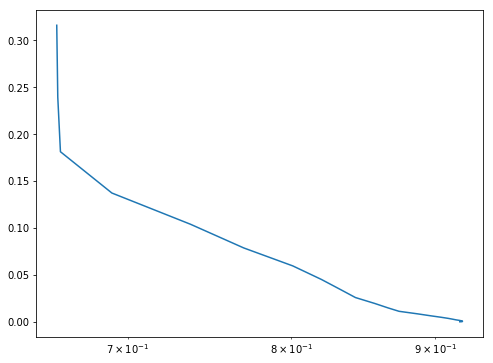

In [36]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# predictors=['x']

# predictors.extend(['x_%d'%i for i in range(2,16)])

#Set the different values of alpha to be tested
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 10

lass = Lasso(random_state = 42)
clf = GridSearchCV(lass, tuned_parameters, cv=n_folds, refit=False)
# X_train, X_test, y_train, y_test
clf.fit(X_train, y_train)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(scores, alphas)

In [37]:
min(scores)

0.66049598187272263

# ELASTIC NET ATTEMPT

In [199]:
np.random.seed(42)

In [41]:
param = {"l1_ratio":np.arange(0,1,.01), "alpha":np.arange(100,1000,50)}
EN_grid = GridSearchCV(ElasticNet(),
                      param,
                      scoring="neg_mean_squared_error", 
                      fit_params=None,
                      n_jobs=5,
                      iid=True,
                      refit=True,
                      return_train_score = True,
                      cv=10)
EN_grid.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'l1_ratio': array([ 0.  ,  0.01, ...,  0.98,  0.99]), 'alpha': array([100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700,
       750, 800, 850, 900, 950])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [44]:
cross_val_score(EN_grid, X_test, y_test)

array([-0.0590472 , -0.0424579 , -0.05717789])

In [45]:
EN_grid.best_score_

-0.046960242499897185

# XGBOOST ATTEMPT

In [ ]:
# need help installing :'(

# GRADIANT BOOST

# RANDOM FOREST REGRESSOR

In [46]:
estimator = RandomForestRegressor()
param_grid = {
    "n_estimators":np.arange(500,750,50),
    "min_samples_split":np.arange(2,8,1),
    "max_features": ["sqrt"],
    "random_state": [42]
}
# X_train

In [47]:
grid= GridSearchCV(estimator,param_grid,
                   n_jobs=5,
                   cv=10,
                   scoring="neg_mean_squared_log_error")

In [48]:
# this will take one metric forever..
grid.fit(X_test,y_test)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=5,
       param_grid={'n_estimators': array([500, 550, 600, 650, 700]), 'min_samples_split': array([2, 3, 4, 5, 6, 7]), 'max_features': ['sqrt'], 'random_state': [42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_log_error', verbose=0)

In [49]:
grid.best_score_
#welp, that is too good to be true

-0.00018457290255967181

In [50]:
grid.best_params_

{'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 500,
 'random_state': 42}

In [63]:
estimator = RandomForestRegressor()
param_grid = {
    "n_estimators":[500],
    "min_samples_split":[2],
    "random_state": [42]
}
grid= GridSearchCV(estimator,param_grid,
                   n_jobs=5,
                   cv=10,
                   scoring="neg_mean_squared_log_error")

In [64]:
grid.fit(X_test,y_test)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=5,
       param_grid={'n_estimators': [500], 'min_samples_split': [2], 'random_state': [42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_log_error', verbose=0)

In [65]:
grid.best_score_


-0.00017831992102114398

## Trying bayesian to get a better understanding on why I am getting such a good score for RF

In [54]:
def rfr(n_estimators, min_samples_split):
    val = cross_val_score(
        RandomForestRegressor(n_estimators=int(n_estimators),
                             min_samples_split=int(min_samples_split),
                              random_state = 42),
        X_train, y_train, cv=10).mean()
    return val

In [55]:
rfr(425,3)

0.88788354582360718

In [16]:
def rf_func(n_estimators, max_depth):
    val = cross_val_score(RandomForestRegressor(n_estimators = int(n_estimators), 
                                                max_depth = int(max_depth),
                                               random_state = 42),
                         X_train, y_train, cv=5).mean()
    return val

In [57]:
rf_BO = BayesianOptimization(rf_func, {'n_estimators': (100,1000), 'max_depth': (10,500)})
rf_BO.explore({"n_estimators":np.arange(200,600,50), 'max_depth':np.arange(100,500,50)})
rf_BO.maximize(n_inter=20)
print(rf_BO.res['max'])
#errors out on the 13th iteration. Not sure why since valid params

Initialization
------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   n_estimators | 
    1 | 00m14s |    0.88650 |    100.0000 |       200.0000 | 
    2 | 00m17s |    0.88679 |    150.0000 |       250.0000 | 
    3 | 00m21s |    0.88660 |    200.0000 |       300.0000 | 
    4 | 00m24s |    0.88650 |    250.0000 |       350.0000 | 
    5 | 00m27s |    0.88662 |    300.0000 |       400.0000 | 
    6 | 00m31s |    0.88675 |    350.0000 |       450.0000 | 
    7 | 00m34s |    0.88683 |    400.0000 |       500.0000 | 
    8 | 00m38s |    0.88686 |    450.0000 |       550.0000 | 
    9 | 00m08s |    0.88623 |    472.7549 |       127.9539 | 
   10 | 00m29s |    0.88669 |    199.0993 |       423.8367 | 
   11 | 00m33s |    0.88687 |    420.9321 |       469.4094 | 
   12 | 00m30s |    0.88678 |     43.4745 |       441.9264 | 
   13 | 00m10s |    0.88540 |     14.9730 |       146.7633 | 


ValueError: Invalid parameter n_inter for estimator GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=Matern(length_scale=1, nu=2.5),
             n_restarts_optimizer=25, normalize_y=False,
             optimizer='fmin_l_bfgs_b',
             random_state=<mtrand.RandomState object at 0x000001F101CACC18>). Check the list of available parameters with `estimator.get_params().keys()`.

In [58]:
estimator.

dict_keys(['bootstrap', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [71]:
estimator = RandomForestRegressor(max_features= 'sqrt',
                                  n_estimators= 550, 
                                  max_depth=450,
                                  random_state=42)
estimator.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=450,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=550, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [87]:
y_pred = estimator.predict(X_test)
rmse(y_pred,y_test)

0.13634625173705103

In [19]:
def en_func(alpha,l1_ratio):
    val = cross_val_score(ElasticNet(alpha = alpha, l1_ratio = l1_ratio, random_state = 42),
                         X_train, y_train, cv=5).mean()
    return val

In [32]:
en_BO = BayesianOptimization(en_func, {'alpha':(1e-4,100), 'l1_ratio':(0,1)})
en_BO.explore({'alpha':np.linspace(1e-4,100,100), 'l1_ratio':np.linspace(0,1,100)})
en_BO.maximize(n_iter=100)
print(elastic_BO.res['max'])

Initialization
------------------------------------------------------
 Step |   Time |      Value |     alpha |   l1_ratio | 
    1 | 00m00s |    0.91195 |    0.0001 |     0.0000 | 
    2 | 00m00s |    0.84471 |    1.0102 |     0.0101 | 
    3 | 00m00s |    0.78394 |    2.0203 |     0.0202 | 
    4 | 00m00s |    0.72324 |    3.0304 |     0.0303 | 
    5 | 00m00s |    0.67149 |    4.0405 |     0.0404 | 
    6 | 00m00s |    0.66688 |    5.0506 |     0.0505 | 
    7 | 00m00s |    0.66575 |    6.0607 |     0.0606 | 
    8 | 00m00s |    0.66351 |    7.0708 |     0.0707 | 
    9 | 00m00s |    0.65989 |    8.0809 |     0.0808 | 
   10 | 00m00s |    0.65462 |    9.0910 |     0.0909 | 
   11 | 00m00s |    0.64744 |   10.1011 |     0.1010 | 
   12 | 00m00s |    0.64320 |   11.1112 |     0.1111 | 
   13 | 00m00s |    0.64299 |   12.1213 |     0.1212 | 
   14 | 00m00s |    0.64281 |   13.1314 |     0.1313 | 
   15 | 00m00s |    0.64260 |   14.1415 |     0.1414 | 
   16 | 00m00s |    0.64232 |   15

  139 | 00m09s |    0.69122 |   95.4829 |     0.0000 | 
  140 | 00m09s |    0.70003 |   65.4191 |     0.0000 | 
  141 | 00m09s |    0.69054 |   98.6032 |     0.0000 | 
  142 | 00m10s |    0.54193 |   43.9282 |     1.0000 | 
  143 | 00m09s |    0.54193 |   31.4309 |     1.0000 | 
  144 | 00m09s |    0.54193 |   36.5276 |     1.0000 | 
  145 | 00m10s |    0.69258 |   89.6359 |     0.0000 | 
  146 | 00m10s |    0.54193 |   48.0126 |     1.0000 | 
  147 | 00m09s |    0.63212 |    7.2588 |     0.9980 | 
  148 | 00m11s |    0.69190 |   92.4906 |     0.0000 | 
  149 | 00m10s |    0.69400 |   84.0866 |     0.0000 | 
  150 | 00m08s |    0.69328 |   86.8315 |     0.0000 | 
  151 | 00m09s |    0.69553 |   78.6488 |     0.0000 | 
  152 | 00m09s |    0.70669 |   51.2351 |     0.0000 | 
  153 | 00m10s |    0.70414 |   56.0646 |     0.0000 | 
  154 | 00m10s |    0.69475 |   81.3471 |     0.0000 | 
  155 | 00m10s |    0.63947 |    4.3213 |     0.9979 | 
  156 | 00m11s |    0.69719 |   73.3470 |     0.

KeyboardInterrupt: 

In [79]:
estimator = ElasticNet(alpha = .0001,
                                  l1_ratio = 0,
                                  random_state=42)
estimator.fit(X_train,y_train)

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=42, selection='cyclic', tol=0.0001, warm_start=False)

In [80]:
y_pred = estimator.predict(X_test)
rmsle(y_pred,y_test)

0.010745718774048955

In [81]:
rf_BO = BayesianOptimization(rf_func, {'n_estimators': (1,1000), 'max_depth': (1,500)})
	rf_BO.explore({'n_estimators': [25, 50, 100, 200, 400], 'max_depth':[10, 40, 80, 320, 500]})
	rf_BO.maximize(n_iter=100)
	print(rf_BO.res['max'])

IndentationError: unexpected indent (<ipython-input-81-a1dde5558839>, line 2)

In [ ]:
def rf_func(n_estimators, max_depth):
	X_train, y_train, X_predict = import_data(name_data = "roger")
	val = cross_val_score(RandomForestRegressor(n_estimators = int(n_estimators), 
                                                max_depth = int(max_depth), 
                                                random_state = 42),
											 X_train, y_train, cv=3).mean()
	return val